Kerrian LE CAILLEC - Thomas MIGLIASSO

## TP Question IV

1. Tracer le prix EDP du call européen dans le modèle de Black & Scholes en fonction de $S_0$,
puis tracer l’écart entre le prix EDP et le prix exact de la formule de Black & Scholes en
fonction de $S_0$.

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm, skew, kurtosis
import scipy.stats.stats as st
import matplotlib.pyplot as plt

In [67]:
K = 100
T = 1
r = 0.05
sigma = 0.2
N = 500
M = 1000
L = 5 * np.log( K)

In [68]:
def call_price_black_scholes(K, T, S0, r, sigma):
    """
    Calculate the Black-Scholes price of a European call option.
    Parameters:
        K (float): Strike price of the option.
        T (float): Time to maturity (in years).
        S0 (float): Current price of the underlying asset.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
    Returns:
        float: The Black-Scholes price of the European call option.
    
    """
    d1 = 1 / (sigma * np.sqrt(T)) * (np.log(S0 / K) + (r + sigma**2 / 2) * T)
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

In [69]:
def compute_tridiagonal_coeffs(sigma, r):
    """
    Compute the matrix diagonals for the Euler's scheme
    Parameters:
    - sigma(float): volatility
    - r(float): risk-free rate
    return:
    - h(float): space step
    - delta_T(float): time step
    - a(float): lower diagonal
    - b(float): main diagonal
    - c(float): upper diagonal
    """
    h = 2 * L / N
    delta_T = T / M
    a = 0.5 * (sigma / h) ** 2 - (r - (sigma**2) / 2) / (2 * h)
    b = -r - (sigma / h) ** 2
    c = 0.5 * (sigma / h) ** 2 + (r - (sigma**2) / 2) / (2 * h)
    return h, delta_T, a, b, c

In [70]:
def euler_scheme(N, M, L, K, r, sigma):
    """
    Compute the Euler scheme for the PDE of the European call option.
    Parameters:
        N (int): Number of space steps.
        M (int): Number of time steps.
        Smax (float): Maximum value of the underlying asset.
        K (float): Strike price of the option.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
    Returns:
        numpy.ndarray: The computed option prices at t=0.
    """
    h, delta_T, a, b, c = compute_tridiagonal_coeffs(sigma, r)
    U = np.zeros((N + 1, M + 1))
    # Initialize U[:, 0] with the payoff of the European call option
    U[:, 0] = np.maximum(np.exp(np.linspace(-L, L, N + 1)) - K, 0)
    # Time-stepping
    for j in range(1, M + 1):
        U[0, j] = 0  # Boundary condition at S=0
        U[-1, j] = np.exp(L) - K * np.exp(-r * (T - j * delta_T))  # Boundary condition at S=Smax
        for i in range(1, N):
            U[i, j] = U[i, j - 1] + delta_T * (
                a * U[i - 1, j - 1] + b * U[i, j - 1] + c * U[i + 1, j - 1]
            )
    return U[:, -1]

In [71]:
Uj = euler_scheme(N, M, L, K, r, sigma)

Text(0, 0.5, 'Price')

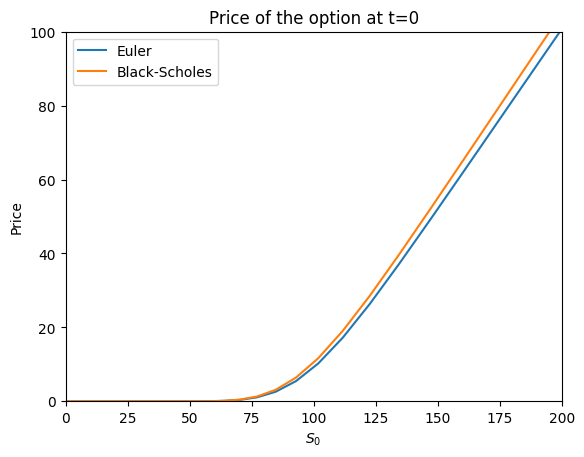

In [72]:
plt.plot(np.exp(np.linspace(-L, L, N - 1)), Uj[1:-1], label="Euler")
plt.plot(
    np.exp(np.linspace(-L, L, N - 1)),
    call_price_black_scholes(
        K, T, np.exp(np.linspace(-L, L, N - 1)), r, sigma
    ),
label="Black-Scholes",
)
plt.title("Price of the option at t=0")
plt.xlabel("$S_0$")
plt.legend()
plt.xlim(0, 200)
plt.ylim(0, 200 - K)
plt.ylabel("Price")

Text(0, 0.5, 'Error')

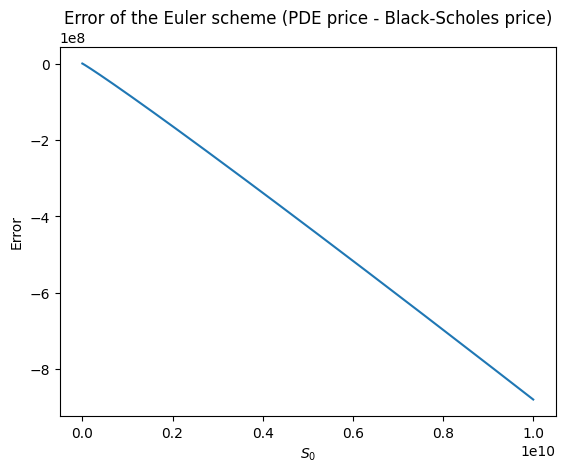

In [73]:
plt.plot(
    np.exp(np.linspace(-L, L, N - 1)),
    Uj[1: -1]
    - call_price_black_scholes(
        K, T, np.exp(np.linspace(-L, L, N - 1)), r, sigma
    ),
)
plt.title("Error of the Euler scheme (PDE price - Black-Scholes price)")
plt.xlabel("$S_0$")
plt.ylabel("Error")


2. Tracer l'erreur en norme $\|\cdot\|_\infty$ du vecteur de prix EDP en fonction de N (à M
suffisamment grand fixé). Retrouve-t-on l’ordre de convergence attendu ? Interpréter la
forme de la courbe.

In [74]:
def absolute_error(L, K, T, sigma, r, N, M, N_range=None, M_range=None):
    """
    Compute the max absolute error of the Euler scheme for different values of N
    parameters:
    - Smax(float): maximum value of the underlying
    - K(float): strike price
    - T(float): maturity
    - sigma(float): volatility
    - r(float): risk-free rate
    - N_range(range): range of N values
    Returns:
    - results(list): list of the max absolute error for N_range
    """
    results = []
    if N_range is not None:
        for N in N_range:
            Uj = euler_scheme(N, M, L, K, r, sigma)
            results.append(
                np.linalg.norm(
                        Uj[1:-1]
                        - call_price_black_scholes(
                            K,
                            T,
                            np.exp(np.linspace(-L, L, N - 1)),
                            r,
                            sigma,
                        ),
                        np.inf,
                )
            )
    if M_range is not None:
        for M in M_range:
            Uj = euler_scheme(N, M, L, K, r, sigma)
            results.append(
                np.linalg.norm(
                        Uj[1:-1]
                        - call_price_black_scholes(
                            K,
                            T,
                            np.exp(np.linspace(-L, L, N - 1)),
                            r,
                            sigma,
                        ),
                        np.inf,
                )
            )
    return results

Text(0, 0.5, 'Max absolute error')

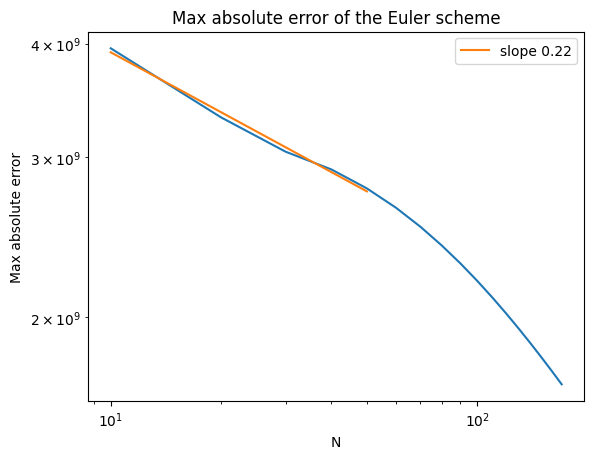

In [76]:
N_range = range(10, 180, 10)
abs_err = absolute_error(L, K, T, sigma, r, N, M, N_range=N_range)
plt.plot(
    N_range,
    abs_err,
)
coeffs = np.polyfit(np.log(N_range)[:5], np.log(abs_err)[:5], 1)
plt.plot(
    N_range[:5],
    np.exp(coeffs[1]) * N_range[:5] ** coeffs[0],
    label=f"slope {-coeffs[0]:.2f}",
)
plt.title("Max absolute error of the Euler scheme")
plt.xlabel("N")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.ylabel("Max absolute error")

Pour $M=10000$ fixé, on remarque que le minimum de l'erreur absolue maximale est autour de $N=300$. Néanmoins on remarque que plus $N$ est grand plus l'erreur augmente, l'approximation en $M$ n'est alors plus suffisante. 

2. Tracer l'erreur en norme $\|\cdot\|_\infty$ du vecteur de prix EDP en fonction de M (à N suffisamment grand fixé). Retrouve-t-on l’ordre de convergence attendu ? Interpréter la
forme de la courbe.

Text(0, 0.5, 'Max absolute error')

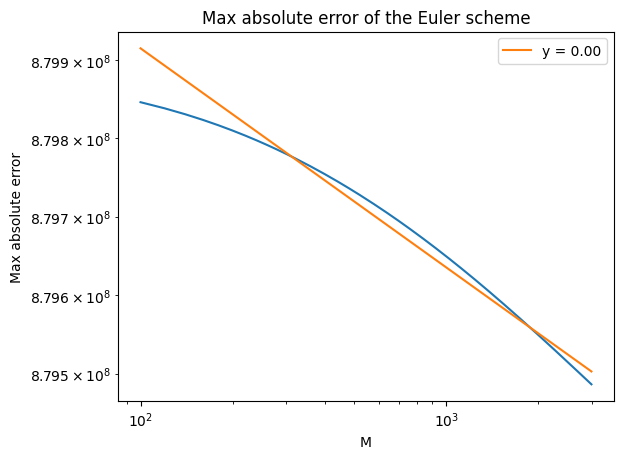

In [78]:
N_range = np.arange(100, 3000, 20)
abs_err = absolute_error(L, K, T, sigma, r, N, M,  M_range=N_range)
plt.plot(
    N_range,
    abs_err,
)
coeffs = np.polyfit(np.log(N_range), np.log(abs_err), 1)
plt.plot(
    N_range,
    np.exp(coeffs[1]) * N_range ** coeffs[0],
    label=f"y = {-coeffs[0]:.2f}",
)
plt.title("Max absolute error of the Euler scheme")
plt.xlabel("M")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.ylabel("Max absolute error")

4. Tracer l’erreur ponctuelle $|u^j_i − u(j\Delta T , y_i )|$ en fonction de $t = T − j\Delta T \in [0, T ]$ et $S = e^{y_i} \in [e^{−L}, e^L]$.

In [ ]:
def pointwise_error(Smax, K, T, sigma, r, N, M):
    """
    Compute the pointwise error of the Euler scheme
    parameters:
    - Smax(float): maximum value of the underlying
    - K(float): strike price
    - T(float): maturity
    - sigma(float): volatility
    - r(float): risk-free rate
    - N(int): number of space steps
    - M(int): number of time steps
    Returns:
    - error(float): pointwise error
    """
    Uij, delta_T = euler_scheme(N, M, Smax, K, r, sigma, full_matrix=True)
    Ubs = np.concatenate(
        [
            call_price_black_scholes(
                K,
                T - j * delta_T,
                np.exp(np.linspace(-L, L, N - 1)),
                r,
                sigma,
            )
            for j in range(M)
        ]
    ).reshape(N - 1, M)
    return np.abs(Uij[1:-1, 1:] - Ubs)

In [ ]:
def plot_heatmap(cmap="viridis"):
    """
    Plots a heatmap for the pointwise error of the Euler scheme

    Parameters:
    - data (numpy.ndarray): The input data array
    - cmap (str): The colormap to use for the heatmap
    """
    errors = pointwise_error(Smax, K, T, sigma, r, N, M)
    plt.figure(figsize=(10, 8))

    plt.imshow(errors, cmap=cmap)
    plt.colorbar()
    plt.title("Heatmap of poitwise error for the Euler scheme given $e^Y$ and $t$")	
    plt.xlabel("$e^Y$")
    plt.ylabel("$t$")
    plt.show()


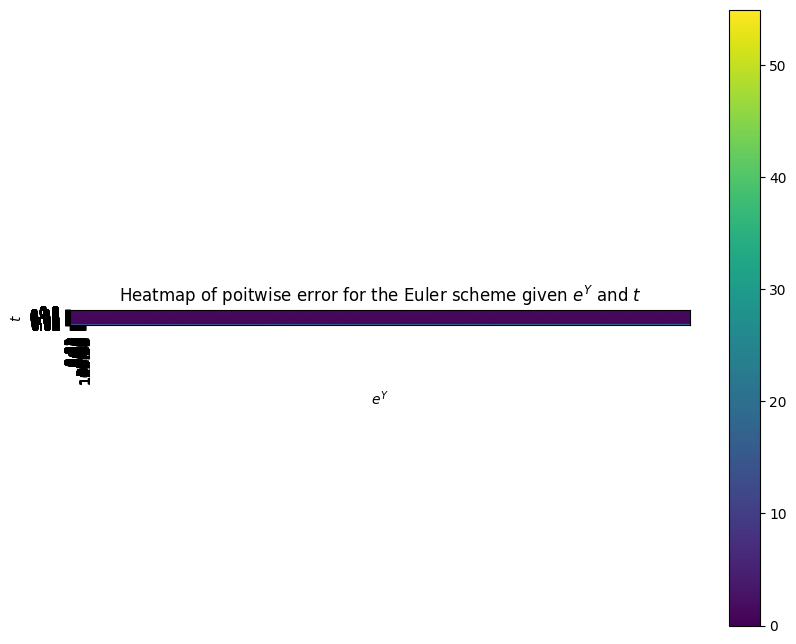

In [146]:
plot_heatmap()